In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [22]:
import os
import random

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from src.models.unet import UNet
import src.config as global_config
from src.data_access.data_generation import DataGenerator
from src.data_access.folds_generation import FoldsGenerator
import src.data_access.config as data_access_config
from src.data_access.utils import prepare_class_weighting, \
    convert_class_weighting_to_vector
from src.evaluation.losses.dice import dice_loss, bce_dice_loss

In [6]:
u_net = UNet(num_classes=len(global_config.CLASS_MAPPINGS) + 1)

In [7]:
model = u_net.build_model(input_shape=(240, 320, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
sub_stack_1_1 (Conv2D)          (None, 240, 320, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
sub_stack_1_2 (Conv2D)          (None, 240, 320, 64) 36928       sub_stack_1_1[0][0]              
__________________________________________________________________________________________________
sub_stack_1_3 (Conv2D)          (None, 240, 320, 64) 36928       sub_stack_1_2[0][0]              
__________________________________________________________________________________________________
sub_stack_

In [9]:
folds_genarator = FoldsGenerator(
    dataset_path=global_config.DATASET_PATH,
    generator_specs=data_access_config.FOLDS_GENERATOR_SPECS
)

In [10]:
dataset_split = next(folds_genarator.generate_folds())

In [11]:
training_set = dataset_split.training_set
test_set = dataset_split.test_set

In [12]:
class_weights = prepare_class_weighting(
    class_balance=training_set.classes_balance,
    class_mapping=global_config.CLASS_MAPPINGS
)

In [13]:
class_weights_vector = convert_class_weighting_to_vector(
    class_weighting=class_weights
)

In [14]:
class_weights

{6: 0.1723363816134394,
 4: 0.15029336928403944,
 1: 0.11239331925278236,
 5: 0.11540385320291446,
 3: 0.2692754920614553,
 2: 0.16156536470990535,
 0: 0.018732219875463727}

In [15]:
class_weights_vector

array([0.01873222, 0.11239332, 0.16156536, 0.2692755 , 0.15029337,
       0.11540385, 0.17233638], dtype=float32)

In [16]:
def loss_function(y_true: np.ndarray, 
                  y_pred: np.ndarray
                 ) -> float:
    print(y_true, y_pred)
    return 1.0 - dice_score(
        y_true=y_true, 
        y_pred=y_pred, 
        classes_weight=class_weights_vector
    )

def dice_metrics(y_true: np.ndarray, 
                 y_pred: np.ndarray
                 ) -> float:
    dice_score(
        y_true=y_true, 
        y_pred=y_pred
    )

In [17]:
training_generator = DataGenerator(
    examples=training_set.examples,
    transformation_chain=data_access_config.TRAINING_TRANSFORMATION_CHAIN,
    batch_size=16
)
test_generator = DataGenerator(
    examples=test_set.examples,
    transformation_chain=data_access_config.VALIDATION_TRANSFORMATION_CHAIN,
    batch_size=16
)

In [18]:
model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics={"dice": dice_loss}
)

In [19]:
model.fit_generator(
    training_generator, 
    epochs=32, 
    verbose=1,
    callbacks=None,
    validation_data=test_generator, 
    max_queue_size=10,
    workers=8,
    use_multiprocessing=False
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/32
32/32 [==============================] - 81s 3s/step - loss: 18.2623 - val_loss: 51.7126
Epoch 2/32
32/32 [==============================] - 79s 2s/step - loss: 16.5742 - val_loss: 47.9595
Epoch 3/32
32/32 [==============================] - 82s 3s/step - loss: 15.2071 - val_loss: 47.3607
Epoch 4/32
32/32 [==============================] - 78s 2s/step - loss: 12.4514 - val_loss: 49.5775
Epoch 5/32
32/32 [==============================] - 80s 3s/step - loss: 8.8948 - val_loss: 53.2302
Epoch 6/32
32/32 [==============================] - 72s 2s/step - loss: 6.8211 - val_loss: 10.3720
Epoch 7/32
32/32 [==============================] - 71s 2s/step - loss: 4.8784 - val_loss: 10.4764
Epoch 8/32
32/32 [==============================] - 77s 2s/step - loss: 4.2232 - val_loss: 11.1712
Epoch 9/32
32/32 [==============================] - 72s 2s/step - loss: 3.8634 - val_loss: 15.5296
Epoch 10/32
32/32 [==============================] - 71s 



In [21]:
model.save(os.path.join(global_config.MODELS_PATH, "u_net.h5"))

In [141]:
test_batch = test_generator[0]

In [142]:
test_sample = test_batch[0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


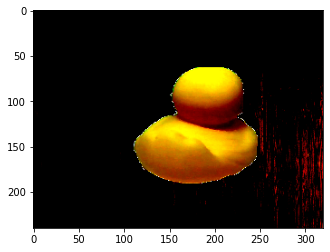

In [143]:
plt.imshow(test_sample)

In [144]:
prediction = model.predict(np.expand_dims(test_sample, axis=0))

In [145]:
prediction = np.argmax(prediction, axis=-1)

In [146]:
prediction = np.squeeze(prediction, axis=0)

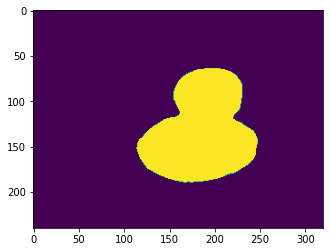

In [147]:
plt.imshow(prediction)

In [148]:
np.max(prediction)

6